## Coursera Capstone Final Project: Where Should a Board Game Café Be Located in Turku? 
#### Tom Bullock

### Introduction

The city of Turku in the southwest of Finland has a large fan base for board games: for a city of with a [population of 191,331](https://www.turku.fi/en/statistical-data-about-turku-2019#Population,%20housing%20and%20education) it possesses three brick and mortar board game shops (with a dedicated board game section in most toy and book shops), and even the public library provides [board game loans (in Finnish)](https://www.turku.fi/lainattavat-lautapelit). To put this in perspective, this is the same number of shops as the capital Helsinki, a city with a [population of 648,042](https://www.hel.fi/hel2/tietokeskus/julkaisut/pdf/20_01_09_tilastollinen_vuosikirja2019.pdf). And yet, despite this, Turku does not possess a board game café, a place where people can socialise, eat, drink and play games or run tabletop campaigns together. Given that Turku is also in possession of [over a dozen escape rooms](https://www.tripadvisor.com/Attractions-g189949-Activities-c56-t208-Turku_Southwest_Finland.html) (and their overlap in customer bases), there is clearly no lack of demand for opportunities to play games together. 

Such a café would likely prove very lucrative within Turku as the closest board game cafés are located in Helsinki and Tampere, both being two hours distance away, and so the main question for a prospective café owner to ask is *which neighbourhood of Turku would be most likely to succeed?* This project intends to answer that by analysing the locations of board game cafés around Europe, as well as centres of major cities that _don't_ have any board game cafés, and determining via a number of classification models which neighbourhoods in Turku would be best suited for housing such a café. This research will be performed with the use of the Foursquare API in order to perform venue queries based on geographical data.

We divide this notebook into the following sections:

* [Data Collection](#Data-Collection)
* [Encoding the Data](#Encoding-the-Data)
* [Training the Model](#Training-the-Model)
* [Applying the Model to Turku Data](#Applying-the-Model-to-Turku-Data)
* [Visualising the results](#Visualising-the-Results)

### Data Collection

The data that we will be using consists of venues surrounding board game cafés, and venues in the centres of cities that do not contain board game cafés, within the continent of Europe. This is built on the hypothesis that these cafés tend to be located within vicinity to certain other types of amnenities, such as public transport hubs, universities or student accommodation, and will be away from others, such as factories or emergency services buildings. 

The data collection is broken down into separate categories:
* [Collecting board game cafés within Europe](#Collecting-Board-Game-Cafés-Within-Europe)
* [Collecting cities within Europe without board game cafés](#Collecting-Cities-Within-Europe-Without-Board-Game-Cafés)
* [Visualising the locations collected](#Visualisation-of-Locations)
* [Obtaining venues close to our collected locations](#Obtaining-Nearby-Venues)

#### Collecting Board Game Cafés Within Europe

The first part of this project requries us to collect the board game cafés located in Europe. Luckily for us, [Andy Matthews at Meeple Mountain](https://www.meeplemountain.com/authors/andy-matthews/) has [collected every board game café on the planet](https://www.meeplemountain.com/articles/the-ultimate-guide-to-board-game-cafes/), and placed them on a handy [Google Map](https://www.google.com/maps/d/u/0/viewer?mid=1UEkafkpKjbEJQzkcwgdtmnYPn4jXQKrw). So all we need to do is extract the entries upon this list that are contained with Europe, and then acquire their latitude and longitude using `geopy`.

Note that the list of cafés is contained in the map as a `kml` file, which we have locally converted to a `csv` file called `Worldwide_Board_Game_Cafe_List.csv`.

In [2]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup # For web scraping
from geopy.geocoders import Nominatim
!pip install folium
import folium


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
world_df = pd.read_csv('Worldwide_Board_Game_Cafe_List.csv')
world_df.head()

,Name,Address,City,PostalCode,Country
0,Geek Out! Argentina,Darregueyra 2484,Buenos Aires,C1425,Argentina
1,The Board Game Cafe,Holmberg 2000,Buenos Aires,1430,Argentina
2,Magic Lair,Avenida Juan Bautista Alberdi 1170,Ciudad de Buenos Aires,1406,Argentina
3,Invictvs Café y Salon de Juegos,Italia 101,Paraná,E3100,Argentina
4,BrainHackr,"208 Prospect Rd, Prospect, South Australia",Adelaide,5082,Australia


The data in the `csv` file does not contain continent information, and so we need to manually filter out cafés that are within Europe. We will do this by first obtaining a list of countries within European from [Wikipedia](https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Europe), which we will then use to test against `world_df`.

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Europe'
response = requests.get(url)
response

<Response [200]>

The Wikipedia table contains multiple columns, and we are only interested in the third; furthermore, each row in the column contains potentially multiple lines, and we only care for the first. However, each country name acts as a hyperlink to the page for that country, and so we can specifically look for the first `a` tag in the third column (`td` in html) of every row (noting that there are 7 columns in the table), adding the result to the list `eu_countries`. 

In [5]:
soup = BeautifulSoup(response.content, 'lxml')
table = soup.find_all('table', attrs={'class':'wikitable'})[1]
eu_countries = [td.a.text for td in table.find_all('td')[2::7]]

The Wikipedia table includes 'United Kingdom', whereas the café list specifies the countries England, Scotland, Wales and Northern Ireland. Hence, to avoid accidentally omitting any of the venues, we replace these values in `eu_countries` (and sort alphabetically again for ease of reading).

In [6]:
eu_countries.remove('United Kingdom')
eu_countries.extend(['England', 'Scotland', 'Wales', 'Northern Ireland'])
eu_countries.sort()

In [7]:
eu_countries[:5]

['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan']

In [8]:
cafe_df = world_df[world_df['Country'].isin(eu_countries)]
cafe_df.reset_index(drop=True, inplace=True)
cafe_df.head()

,Name,Address,City,PostalCode,Country
0,Brot & Spiele,Mariahilferstraße 17,Graz,8020,Austria
1,Brot und Spiele,Laudongasse 22,Vienna,1080,Austria
2,Café Benno,Alser Str. 67,Vienna,1080,Austria
3,Café Sperlhof,Große Sperlgasse 41,Vienna,1020,Austria
4,SpielBar,Lederergasse 26,Vienna,1080,Austria


Later data cleaning shows that the café Chil Angart in Krasnodar is missing from the original list, and rather than have it cause problems later we will add it to the data now.

In [9]:
chil_angart = {
    'Name': 'Чил Ангарт',
    'Address': 'Krasnaya Street 109',
    'City': 'Krasnodar',
    'PostalCode': '350000',
    'Country': 'Russia'
              }
cafe_df = cafe_df.append(chil_angart, ignore_index=True)
cafe_df.tail()

,Name,Address,City,PostalCode,Country
291,Da Vinci Board Game Cafe,Kazakistan Cd. 69-71 D:A,Ankara,6490,Turkey
292,Goblin Oyun Cafe,General Asim Gunduz,Kadikoy/Istanbul,34714,Turkey
293,Chance & Counters,23 High Street,Cardiff,CF10 1PT,Wales
294,"Board, Isle of Wight",St James Street,Newport,PO30 1LQ,Wales
295,Чил Ангарт,Krasnaya Street 109,Krasnodar,350000,Russia


There is no latitude and longitude data contained within the original `kml` file, and so we need to collect it ourselves. This will be done with `geopy`, after checking the [list of supported countries](https://pgeocode.readthedocs.io/en/latest/overview.html#supported-countries) for `pgeocode` revealed that a number of countries of interest are not covered.

We will create a list of dictionaries to create a Dataframe, which will ultimately be merged with `cafe_df`.

In [10]:
# Initialise the geolocator and list of geodata dictionaries
geolocator = Nominatim(user_agent='bgc_finder')

Foursquare utilises latitude and longitude values, which can be obtained from a given address by making use of Open Street Maps' Nominatim search system, so we now define a quick function that will perform a Nominatim query. Depending on the given data (essentially, whether we consider cafés or cities without them, as we will do later) the query will be in the format `[Address], [PostalCode] [City], [Country]` or simply `[City]`, and will return a list containing the latitude and longitude. (In the latter case Nominatim will provide the latitude and longitude for a point in the center of the city.) 

If our query does not produce a result (due to issues in the initial data, or some disagreement between Nominatim and Google Maps) then the function returns a list of `NaN` values.

In [11]:
def get_address(row):
    # This case deals with the cafe data
    if len(row) > 2: 
        address = f"{row[1]}, {row[3]} {row[2]}, {row[4]}"
    # This deals with cities without cafes
    else:
        address = row[1]

    return address

In [12]:
geocode_cache = {} # For storing already found addresses

def get_latlong(row):
    address = get_address(row)
    
    # Check to see if the address is unchanged
    if (address in geocode_cache):
        return geocode_cache[address]
    
    location = geolocator.geocode(address)
    
    try:
        geocode_cache[address] = [location.latitude, location.longitude]
        return [location.latitude, location.longitude]
    except:
        geocode_cache[address] = [np.nan, np.nan]
        return [np.nan, np.nan]

In [13]:
def build_latlong_dataframe(source_df):
    latlong_list = []
    city_idx = source_df.columns.get_loc('City')
    # Building the list of geodata
    latlong_list = [{'Name': row[0], 
                     'City': row[city_idx], 
                     'Latitude': get_latlong(row)[0], 
                     'Longitude': get_latlong(row)[1]}
                    for row in source_df.to_numpy()]

    # Build the DataFrame
    latlong_df = pd.DataFrame(latlong_list)
    return latlong_df

In [14]:
latlong_df = build_latlong_dataframe(cafe_df)
latlong_df.head()

,Name,City,Latitude,Longitude
0,Brot & Spiele,Graz,47.073272,15.433036
1,Brot und Spiele,Vienna,48.213407,16.349799
2,Café Benno,Vienna,48.215050,16.342587
3,Café Sperlhof,Vienna,48.219658,16.378380
4,SpielBar,Vienna,48.213688,16.348476


In order to determine which, if any, rows are missing data, we now do a search over the database for null values. This then allows us to clean the data. There is still the potential issue of duplicate values, but we will resolve that after.

In [15]:
def find_missing_values(source_df):
    null_idx = source_df.index[source_df['Latitude'].isnull()].tolist()
    print(f'There are {len(null_idx)} rows missing data.')

    if len(null_idx) > 0:
        return cafe_df.loc[null_idx,:]

In [16]:
missing_df = find_missing_values(latlong_df)
missing_df

There are 52 rows missing data.


,Name,Address,City,PostalCode,Country
16,Yam-toto,En Hors-Chateau 43,Liège,4000,Belgium
17,Aux 3D Board Game Cafe,"Place Abbe Joseph, 11",Namur,5000,Belgium
38,Ready Steady Roll,Ivy Lodge,Bedford,MK44 1ND,England
42,The Games Table,"86 Magdalen St, Norwich",Norwich,NR311JF,England
43,Ready Steady Roll,"Ivy Lodge, A6 Rushden Road",Sharnbrook,MK44 1ND,England
44,"Ready, Steady Roll","Studio 5, Ivy Lodge Farm, A6 Rushden Road",Sharnbrook,MK44 1ND,England
48,Red Panda Gaming Cafe,"247 High Street, First floor",Lincoln,LN2 1HW,England
72,c:\ Side Quest,"11 Lower Promenade, Madiera Drive",Brighton,BN2 1ET,England
73,Dice Saloon,"Unit 6, Longley Industrial Estate, New England...",Brighton,BN14GY,England
74,Dice Saloon,"First floor, Vantage Point, New England Road",Brighton,BN1 4GY,England


So there are a number of issues within the data, including a peculiar issue with #220 (Pontyridd is within Wales, not Italy!). This also highlights that we do have some duplicates within our data (see e.g. #43 and #44), and a few instances of cities containing unnecessary whitespace at the end, which will be problematic later. So let's clean the data. 

(Unfortunately, since we are dealing with a number of countries, and a number of different address standards, this cleaning will need to mostly be done by hand and checked against the [Nominatim search](nominatim.openstreetmap.org/).)

In [17]:
cafe_df['City'] = cafe_df.apply(lambda x: x.City.rstrip(), axis=1)
cafe_df.loc[7, 'City'] = 'Antwerp'
cafe_df.drop(8, axis=0, inplace=True)
cafe_df.loc[12, 'City'] = 'Brussels'
cafe_df.loc[16, 'Address'] = 'Rue Hors-Château 43'
cafe_df.loc[17, 'Address'] = 'Place Abbé Joseph André 11'
cafe_df.drop(33, axis=0, inplace=True)
cafe_df.loc[38, 'Address'] = 'Rushden Rd' # This is as accurate as Nominatim can get
cafe_df.loc[42, 'PostalCode'] = 'NR2 1EL'
cafe_df.drop(43, axis=0, inplace=True)
cafe_df.drop(44, axis=0, inplace=True)
cafe_df.loc[48, 'Address'] = '247 High Street'
cafe_df.drop(50, axis=0, inplace=True)
cafe_df.loc[61, 'City'] = 'Newcastle-upon-Tyne'
cafe_df.drop(72, axis=0, inplace=True)
cafe_df.loc[73, 'Address'] = '88 London Rd'
cafe_df.loc[73, 'PostalCode'] = 'BN1 4JF'
cafe_df.drop(74, axis=0, inplace=True)
cafe_df.loc[75, 'Address'] = '' # Needed in order for geopy to obtain geographical data
cafe_df.drop(79, axis=0, inplace=True)
cafe_df.loc[82, 'Address'] = 'Abinger place'
cafe_df.loc[84, 'Address'] = '207 Queensway'
cafe_df.loc[84, 'PostalCode'] = 'MK2 2EB'
cafe_df.loc[86, 'Address'] = '149 Albert Rd'
cafe_df.loc[89, 'Address'] = 'The Brooks Centre'
cafe_df.loc[103, 'Address'] = '19a Pepper Street'
cafe_df.loc[103, 'PostalCode'] = 'ST5 1PR'
cafe_df.loc[104, 'Name'] = 'Nerdy Coffee Co.'
cafe_df.loc[124, 'PostalCode'] = '03000'
cafe_df.loc[185, 'Address'] = 'Lehener Straße 15'
cafe_df.loc[194, 'Address'] = 'Λογοθετίδη Βασίλη 14'
cafe_df.loc[194, 'City'] = 'Athens'
cafe_df.loc[196, 'PostalCode'] = '65302'
cafe_df.loc[197, 'PostalCode'] = '41221'
cafe_df.loc[198, 'Address'] = 'Δημητριου Ράλλη 4'
cafe_df.loc[200, 'Address'] = 'Γεωργίου Παπανδρέου 27'
cafe_df.loc[200, 'PostalCode'] = '54645'
cafe_df.loc[202, 'Address'] = 'Βασιλίσσης Σοφίας'
cafe_df.loc[205, 'Address'] = 'Ferenc körút 17'
cafe_df.drop(206, axis=0, inplace=True)
cafe_df.loc[207, 'Name'] = 'Pub Game Up!'
cafe_df.loc[211, 'Address'] = '9 High Street'
cafe_df.loc[211, 'PostalCode'] = 'P75 XW35'
cafe_df.drop(212, axis=0, inplace=True)
cafe_df.loc[213, 'Address'] = '51 Wellington Quay'
cafe_df.loc[214, 'PostalCode'] = 'D02 FP40'
cafe_df.loc[215, 'PostalCode'] = 'H91 Y90F'
cafe_df.loc[216, 'Address'] = 'Via Giuseppe Toniolo 12'
cafe_df.drop(220, axis=0, inplace=True) # This is in fact related to an event called Counters in Pontypridd, Wales, not Italy
cafe_df.loc[223, 'Address'] = 'Strada Alexandr Pușkin 52'
cafe_df.loc[223, 'PostalCode'] = 'MD-2012'
cafe_df.loc[224, 'PostalCode'] = '1432KA'
cafe_df.loc[225, 'PostalCode'] = '1052NP'
cafe_df.loc[227, 'PostalCode'] = '4811GK'
cafe_df.loc[228, 'PostalCode'] = '2611HR'
cafe_df.loc[229, 'PostalCode'] = '2801LV'
cafe_df.loc[230, 'PostalCode'] = '9712NP'
cafe_df.loc[231, 'PostalCode'] = '2011LE'
cafe_df.loc[232, 'PostalCode'] = '2513BW'
cafe_df.loc[233, 'City'] = 'Skopje'
cafe_df.loc[234, 'Address'] = 'Rosepark, Upper Newtownards Road' # This is as accurate as Nominatim allows
cafe_df.loc[234, 'City'] = 'Dundonald'
cafe_df.loc[234, 'PostalCode'] = 'BT4 3SB'
cafe_df.loc[235, 'Address'] = 'Holywood Road'
cafe_df.loc[235, 'City'] = 'Sydenham'
cafe_df.loc[235, 'PostalCode'] = 'BT4 1NT'
cafe_df.loc[238, 'Address'] = 'Dmowskiego 15'
cafe_df.loc[239, 'Address'] = 'Kamienna 7'
cafe_df.loc[248, 'Name'] = 'Ludoclube'
cafe_df.loc[248, 'PostalCode'] = '2720-046'
cafe_df.loc[249, 'Name'] = 'Pow Wow'
cafe_df.loc[249, 'Address'] = 'Rua Professor Fernando da Fonseca 19'
cafe_df.loc[249, 'PostalCode'] = '1600-235'
cafe_df.loc[250, 'Name'] = 'A Jogar é que a gente se entende'
cafe_df.loc[250, 'Address'] = 'Rua Doutor Elias de Aguiar 244'
cafe_df.loc[250, 'PostalCode'] = '4480-789'
cafe_df.loc[252, 'Name'] = 'Snakes & Wizards'
cafe_df.loc[252, 'Address'] = 'Strada Ilarie Chendi 5'
cafe_df.loc[253, 'Address'] = 'Strada Samuil Micu 4'
cafe_df.loc[256, 'Name'] = 'FatCats Board Game Cafe'
cafe_df.loc[256, 'PostalCode'] = '100337'
cafe_df.drop(264, axis=0, inplace=True)
cafe_df.drop(272, axis=0, inplace=True)
cafe_df.loc[280, 'Address'] = "Carrer de l'Alandir 1" # The actual address "Carrer Hospitalers de Sant Joan n.2" is a footpath so doesn't show
cafe_df.loc[282, 'Address'] = 'Av. Manuel Torres 5' # In Nominatim the 'de' given in Google Map returns an error
cafe_df.loc[284, 'Address'] = 'Carrer de Rosselló i Cazador, 7'
cafe_df.loc[286, 'PostalCode'] = '411 19'
cafe_df.loc[291, 'PostalCode'] = '06490'
cafe_df.loc[292, 'Address'] = 'Nail Bey Sk. No:48/2' # In Nominatim the street name is Nail Bey, not Nailbey as with Google Maps
cafe_df.loc[292, 'City'] = 'Istanbul'

With the values cleaned up and duplicates removed, let's reset the index. Also, let's group the cafés in terms of countries and cities, as this was previously not the case (possibly due to some cafés being assigned a region that affected the results).

In [18]:
cafe_df.sort_values(['Country', 'City'], inplace=True)
cafe_df.reset_index(drop=True, inplace=True)
cafe_df.head()

,Name,Address,City,PostalCode,Country
0,Brot & Spiele,Mariahilferstraße 17,Graz,8020,Austria
1,Brot und Spiele,Laudongasse 22,Vienna,1080,Austria
2,Café Benno,Alser Str. 67,Vienna,1080,Austria
3,Café Sperlhof,Große Sperlgasse 41,Vienna,1020,Austria
4,SpielBar,Lederergasse 26,Vienna,1080,Austria


So let's run the geolocator function again, and see if we now have geodata for each café:

In [19]:
latlong_df = build_latlong_dataframe(cafe_df)
missing_df = find_missing_values(latlong_df)
missing_df

There are 0 rows missing data.


So now we have no missing data, let's combine the two dataframes for future use.

In [20]:
cafe_df = cafe_df.merge(latlong_df, on=['Name', 'City'])
cafe_df.head()

,Name,Address,City,PostalCode,Country,Latitude,Longitude
0,Brot & Spiele,Mariahilferstraße 17,Graz,8020,Austria,47.073272,15.433036
1,Brot und Spiele,Laudongasse 22,Vienna,1080,Austria,48.213407,16.349799
2,Café Benno,Alser Str. 67,Vienna,1080,Austria,48.215050,16.342587
3,Café Sperlhof,Große Sperlgasse 41,Vienna,1020,Austria,48.219658,16.378380
4,SpielBar,Lederergasse 26,Vienna,1080,Austria,48.213688,16.348476


#### Collecting Cities Within Europe Without Board Game Cafés

In order for us to have negative data, we need to collect regions within Europe that do not contain board game cafés. To this end we utilise the list of [the 500 largest European cities given by City Mayors](http://www.citymayors.com/features/euro_cities.html), and from this list remove any instances of cities that are also contained within `cafe_df`. 

With this list of cities we then utilise `geopy` to find the latitude and longitude of central points within each city, that will then be later used with the Foursquare API.

In [21]:
city_list = []
for n in range(1, 6):
    # The City Mayors list runs over 5 pages, hence the loop
    url = f'http://www.citymayors.com/features/euro_cities{n}.html'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    table = soup.find_all('table')[1]
    city_table = [td.text.title().rstrip() for td in table.find_all('td', attrs={'width':'140'})[1:]]
    city_list.extend(city_table)

Unfortunately, the data on City Mayors omits Turkey, and so we need to collect this information from [Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_cities_and_towns_in_Turkey). The smallest population value given in the City Mayors table is 149,000 people, and so we will include all cities whose population exceed this value.

In addition, a number of English counties, rather than cities are within the data, so we shall remove those, and we need to include 'Rome' instead of 'Roma' to ensure it is properly treated.

In [22]:
# Replacing 'Roma' with 'Rome'
city_list = list(map(lambda x: x.replace('Roma', 'Rome'), city_list))

In [23]:
# Collecting and adding Turkish cities to the list
turkey_url = 'https://en.wikipedia.org/wiki/List_of_largest_cities_and_towns_in_Turkey'
turkey_resp = requests.get(turkey_url)
turkey_soup = BeautifulSoup(turkey_resp.content, 'lxml')
turkey_table = turkey_soup.find('table', attrs={'class': 'sortable'})
city_pop = [td.text.rstrip('\n').replace(',', '') for td in turkey_table.find_all('td')[6::8]]
turkey_cities = [a.text for a in turkey_table.find_all('a')[::2]]

for city, pop in zip(turkey_cities, city_pop):
    # At least one population value given by Wikipedia is '-', and so we pass over any such cities
    try:
        if int(pop) > 149000:
            city_list.append(city)
    except:
        pass
print(f'city_list now contains {len(city_list)} cities')

city_list now contains 543 cities


In [24]:
# Removing English counties
for city in city_list:
    if 'shire' in city:
        city_list.remove(city)
print(f'city_list now contains {len(city_list)} cities')

city_list now contains 534 cities


We now take the cities listed in `cafe_df` and, rather than directly remove them from `city_list`, we create a new list `city_without_cafe` that only contains cities without a board game café.

In [25]:
cafe_city_list = cafe_df['City'].unique().tolist()
cafe_city_list.sort()
city_list.sort()
city_without_cafe = []

In [26]:
def has_a_cafe(city):
    # A quick function to determine if a city appears in cafe_df
    inclusion = [(cafe.lower() in city.lower()) for cafe in cafe_city_list]
    return any(inclusion)

In [27]:
for city in city_list:
    if not has_a_cafe(city):
        city_without_cafe.append(city)
print(f'\ncity_without_cafe has {len(city_without_cafe)} cities')


city_without_cafe has 438 cities


In [28]:
# Test that we are getting a suitable output
city_without_cafe[:5]

['Aachen', 'Abakan', 'Aberdeen', 'Adana', 'Adapazarı']

In [29]:
column_order = ['Name', 'City']

cwc_df = pd.DataFrame(city_without_cafe, columns=['City'])
cwc_df['Name'] = np.nan
cwc_df = cwc_df.reindex(columns=column_order)
cwc_df.head()

,Name,City
0,NaN,Aachen
1,NaN,Abakan
2,NaN,Aberdeen
3,NaN,Adana
4,NaN,Adapazarı


There are some data points that either do not given a result with `geopy`, or point to the wrong location (e.g. Van, in Turkey, gets mistaken for Vietnam), so let's fix those.

In [30]:
cwc_df.loc[34] = 'Bila Tserkva'
cwc_df.loc[80] = 'Chernivtsi'
cwc_df.loc[90] = 'Kamianske'
cwc_df.loc[100] = 'Yekaterinburg'
cwc_df.loc[135] = 'Yoshkar-Ola'
cwc_df.loc[176] = 'Kremenchuk'
cwc_df.loc[208] = 'Makiivka'
cwc_df.loc[242] = 'Nizhnevartovsk'
cwc_df.loc[258] = 'Oldham, Greater Manchester'
cwc_df.loc[279] = 'Piraeus'
cwc_df.drop(293, axis=0, inplace=True) # Rhondda Cynon Taf is a Welsh county whose largest town has less than 31000 people
cwc_df.loc[344] = 'Stary Oskol'
cwc_df.loc[355] = 'Syktyvkar'
cwc_df.drop(380, axis=0, inplace=True) # We perhaps don't want Turku within our training data
cwc_df.loc[389] = 'Yuzhno-Sakhalinsk'
cwc_df.loc[392] = 'Van, İpekyolu'
cwc_df.loc[400] = 'Vinnytsia'
cwc_df.loc[420] = 'Yaroslavl'

In [31]:
cwc_df = build_latlong_dataframe(cwc_df)
print(cwc_df.shape)
cwc_df.head()

(436, 4)


,Name,City,Latitude,Longitude
0,NaN,Aachen,50.776351,6.083862
1,NaN,Abakan,53.720661,91.440369
2,NaN,Aberdeen,57.148243,-2.092809
3,NaN,Adana,36.993617,35.325835
4,NaN,Adapazarı,40.784799,30.399683


In [32]:
missing_df = find_missing_values(cwc_df)
missing_df

There are 0 rows missing data.


Because of the size of Russia, there are a number of cities that are contained within Asia. As such, we will drop any cities that are East of the Ural mountains (whose longitude according to [Wikipedia](https://en.wikipedia.org/wiki/Ural_Mountains) is 60E).

In [33]:
asia_idx = cwc_df[cwc_df['Longitude'] > 60].index
cwc_df.drop(asia_idx, inplace=True)
cwc_df.reset_index(drop=True, inplace=True)
print(cwc_df.shape)
cwc_df.head()

(402, 4)


,Name,City,Latitude,Longitude
0,NaN,Aachen,50.776351,6.083862
1,NaN,Aberdeen,57.148243,-2.092809
2,NaN,Adana,36.993617,35.325835
3,NaN,Adapazarı,40.784799,30.399683
4,NaN,Adıyaman,37.789360,38.314110


#### Visualisation of Locations

Below is a plot of the points that we have collected, with green points denoting board game cafés within Europe, and orange points the centres of cities that do not have a board game café.

In [34]:
# EU centre point
latitude, longitude = 50, 20

map_eu = folium.Map(location=[latitude, longitude], zoom_start=4)

cafe_label = folium.FeatureGroup(name='Cafés')
cwc_label = folium.FeatureGroup(name='Cities without cafés')

map_eu.add_child(cafe_label)
map_eu.add_child(cwc_label)

for lat, lng, cafe, city in zip(cafe_df['Latitude'], cafe_df['Longitude'], cafe_df['Name'], cafe_df['City']):
    label = f'{cafe}, {city}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5,
        popup=label,
        color='#80cb34',
        weight=2,
        fill=True,
        fill_color='#CBCB34',
        fill_opacity=0.8,
        parse_html=False).add_to(cafe_label)
    
for lat, lng, city in zip(cwc_df['Latitude'], cwc_df['Longitude'], cwc_df['City']):
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5,
        popup=label,
        color='#f96706',
        weight=2,
        fill=True,
        fill_color='#F9E106',
        fill_opacity=0.8,
        parse_html=False).add_to(cwc_label)

folium.LayerControl(collapsed=False).add_to(map_eu)
    
map_eu

#### Obtaining Nearby Venues

Now that we have each location, we need to obtain the venues within their immediate vicinity by making use of the Foursquare API. We shall obtain the limit of 100 locations offered by Foursquare for free users within a radius of 400 metres of the points in our databases.

In addition, to prevent adding some tautological bias into our subsequent model, we will remove the instances of our board game cafés whenever they appear in our data to the best of our ability, especially if they are specifically labelled with the category 'Gaming cafe' (with [Foursquare code](https://developer.foursquare.com/docs/build-with-foursquare/categories/) `4bf58dd8d48988d18d941735`).

In [35]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 

In [36]:
VERSION = '20180605'
RADIUS = 400
LIMIT = 100
CAT_ID = '4bf58dd8d48988d18d941735'# Foursquare category ID for gaming cafés

In [37]:
def get_local_venues(df, col_dict, inc_cat_id=False):
    venue_list = []
    old_columns = list(col_dict.keys())
    new_columns = list(col_dict.values())
    
    old_columns.extend(['Latitude', 'Longitude'])
    
    for row in df[old_columns].to_numpy():
        lat, lng = row[-2:]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            RADIUS,
            LIMIT)
        results = requests.get(url).json()
        for result in results['response']['venues']:
            if len(result['categories']) > 0:
                venue = dict()
                for n, key  in enumerate(new_columns):
                    venue[key] = row[n]
                venue['Venue_name'] = result['name']
                venue['Venue_cat'] = result['categories'][0]['name']
                if inc_cat_id:
                    venue['Venue_catID'] = result['categories'][0]['id']
                venue_list.append(venue)
    return pd.DataFrame(venue_list)

In [38]:
columns = {'Name': 'Café_name', 'City': 'Café_city'} 
venue_df = get_local_venues(cafe_df, col_dict=columns, inc_cat_id=True)
print(venue_df.shape)
venue_df.head()

(25703, 5)


,Café_name,Café_city,Venue_name,Venue_cat,Venue_catID
0,Brot & Spiele,Graz,Brot & Spiele,Bar,4bf58dd8d48988d116941735
1,Brot & Spiele,Graz,Mursteg,Bridge,4bf58dd8d48988d1df941735
2,Brot & Spiele,Graz,Noël,Bar,4bf58dd8d48988d116941735
3,Brot & Spiele,Graz,Die Scherbe,Bar,4bf58dd8d48988d116941735
4,Brot & Spiele,Graz,Paul & Bohne,Coffee Shop,4bf58dd8d48988d1e0931735


In [39]:
reduced_venue_df = venue_df.copy() # To preserve venue_df

# Create a list of unique café names in lower case, with instances where 
# 'café' and 'cafe' being the only difference removed
cafe_list = {cafe.lower() for cafe in cafe_df['Name'].unique()}
cafe_list = {cafe.replace('café', 'cafe') for cafe in cafe_list}

# Ensuring that venues that only differ in the spelling of 'café' are treated the same
venue_df['Venue_name'] = venue_df['Venue_name'].apply(lambda x: x.replace('Café', 'Cafe'))
venue_df['Café_name'] = venue_df['Café_name'].apply(lambda x: x.replace('Café', 'Cafe'))

# Removing a similar issue with some German cafés that differ in using '&' or 'und'
venue_df['Venue_name'] = venue_df['Venue_name'].apply(lambda x: x.replace('und', '&'))
venue_df['Café_name'] = venue_df['Café_name'].apply(lambda x: x.replace('und', '&'))

# Conditional on a venue either being classed as board game café or being in cafe_list
to_remove = venue_df.apply(lambda x: x['Venue_catID'] == '4bf58dd8d48988d18d941735' or 
                           x['Venue_name'].lower() in cafe_list or
                           any([cafe.lower() in x['Venue_name'].lower() for cafe in cafe_list]), 
                           axis=1
                          )

print(f"We shall remove {to_remove.sum()} elements")

# Get the indices of venues to remove
idx_to_remove = np.where(to_remove == True)[0]

# Drop the venues that were True in to_remove
reduced_venue_df.drop(idx_to_remove, inplace=True)
reduced_venue_df.reset_index(drop=True, inplace=True)
print(f"We now have {reduced_venue_df.shape[0]} data points")

reduced_venue_df.head(10)

We shall remove 189 elements
We now have 25514 data points


,Café_name,Café_city,Venue_name,Venue_cat,Venue_catID
0,Brot & Spiele,Graz,Mursteg,Bridge,4bf58dd8d48988d1df941735
1,Brot & Spiele,Graz,Noël,Bar,4bf58dd8d48988d116941735
2,Brot & Spiele,Graz,Die Scherbe,Bar,4bf58dd8d48988d116941735
3,Brot & Spiele,Graz,Paul & Bohne,Coffee Shop,4bf58dd8d48988d1e0931735
4,Brot & Spiele,Graz,Offline Retail,Thrift / Vintage Store,4bf58dd8d48988d101951735
5,Brot & Spiele,Graz,Erich-Edegger-Steg,Bridge,4bf58dd8d48988d1df941735
6,Brot & Spiele,Graz,Hotel Feichtinger Graz,Hotel,4bf58dd8d48988d1fa931735
7,Brot & Spiele,Graz,Minoritensaal,Historic Site,4deefb944765f83613cdba6e
8,Brot & Spiele,Graz,The Hungry Heart - American Street Food,Hot Dog Joint,4bf58dd8d48988d16f941735
9,Brot & Spiele,Graz,Stigergasse,Residential Building (Apartment / Condo),4d954b06a243a5684965b473


In [40]:
columns = {'Name': 'Café_name', 'City': 'Café_city'} 
cwc_venue_df = get_local_venues(cwc_df, col_dict=columns, inc_cat_id=True)
cwc_venue_df.head()

,Café_name,Café_city,Venue_name,Venue_cat,Venue_catID
0,NaN,Aachen,Rathaus,City Hall,4bf58dd8d48988d129941735
1,NaN,Aachen,Markt,Plaza,4bf58dd8d48988d164941735
2,NaN,Aachen,Krönungssaal,History Museum,4bf58dd8d48988d190941735
3,NaN,Aachen,Starbucks,Coffee Shop,4bf58dd8d48988d1e0931735
4,NaN,Aachen,REWE CITY,Supermarket,52f2ab2ebcbc57f1066b8b46


Just to make sure, we check that there are no board game cafés that were not contained within the original `csv` file.

In [41]:
cwc_venue_df[cwc_venue_df['Venue_catID'] == CAT_ID]

,Café_name,Café_city,Venue_name,Venue_cat,Venue_catID
544,NaN,Afyon,sülümenli kasabasi elmas int cafe,Gaming Cafe,4bf58dd8d48988d18d941735
6414,NaN,Cherepovets,Антикафе,Gaming Cafe,4bf58dd8d48988d18d941735
7439,NaN,Diyarbakır,Me in cafe,Gaming Cafe,4bf58dd8d48988d18d941735
9850,NaN,Gateshead,Chisholm Bookmakers,Gaming Cafe,4bf58dd8d48988d18d941735
10806,NaN,Gorlovka,"Компьютерный клуб ""КУБ""",Gaming Cafe,4bf58dd8d48988d18d941735
20442,NaN,Nikopol,Superbet Turnu Magurele,Gaming Cafe,4bf58dd8d48988d18d941735
21485,NaN,Oberhausen,Cardgalaxy,Gaming Cafe,4bf58dd8d48988d18d941735
27984,NaN,Simferopol,лавка чудес,Gaming Cafe,4bf58dd8d48988d18d941735
30729,NaN,Tambov,Time Club,Gaming Cafe,4bf58dd8d48988d18d941735
31797,NaN,Tolyatti,Интеллектуальное кафе ИНСАЙТ,Gaming Cafe,4bf58dd8d48988d18d941735


Upon cross-examinging these venues with Google Maps, we find that they fall into eight categories: they are an internet café, a betting shop, a toy shop, an arcade, a gift shop, a mental health office, a hookah bar, or they do not seem to exist anymore. We shall relabel these accordingly, and delete those that fit into this last category. (Note that Foursquare is inconsistent with the venues it returns, so these numbers will vary.)

In [42]:
incorrect_cat = cwc_venue_df.index[cwc_venue_df['Venue_catID'] == CAT_ID].tolist()

# Fix the internet cafés

cwc_venue_df.loc[incorrect_cat[0]]['Venue_cat'] = 'Internet cafe'
cwc_venue_df.loc[incorrect_cat[0]]['Venue_catID'] = '4bf58dd8d48988d1f0941735'

# Fix the betting shops

cwc_venue_df.loc[incorrect_cat[3]]['Venue_cat'] = 'Betting Shop'
cwc_venue_df.loc[incorrect_cat[3]]['Venue_catID'] = '52f2ab2ebcbc57f1066b8b40'
cwc_venue_df.loc[incorrect_cat[5]]['Venue_cat'] = 'Betting Shop'
cwc_venue_df.loc[incorrect_cat[5]]['Venue_catID'] = '52f2ab2ebcbc57f1066b8b40'
cwc_venue_df.loc[incorrect_cat[11]]['Venue_cat'] = 'Betting Shop'
cwc_venue_df.loc[incorrect_cat[11]]['Venue_catID'] = '52f2ab2ebcbc57f1066b8b40'

# Fix the toy shop

cwc_venue_df.loc[incorrect_cat[6]]['Venue_cat'] = 'Toy / Game Store'
cwc_venue_df.loc[incorrect_cat[6]]['Venue_catID'] = '4bf58dd8d48988d1f3941735'

# Fix the arcade

cwc_venue_df.loc[incorrect_cat[8]]['Venue_cat'] = 'Arcade'
cwc_venue_df.loc[incorrect_cat[8]]['Venue_catID'] = '4bf58dd8d48988d1e1931735'

# Fix the gift shop

cwc_venue_df.loc[incorrect_cat[7]]['Venue_cat'] = 'Gift Shop'
cwc_venue_df.loc[incorrect_cat[7]]['Venue_catID'] = '4bf58dd8d48988d128951735'

# Fix the mental health office

cwc_venue_df.loc[incorrect_cat[9]]['Venue_cat'] = 'Mental Health Office'
cwc_venue_df.loc[incorrect_cat[9]]['Venue_catID'] = '52e81612bcbc57f1066b7a39'

# Fix the hookah bar

cwc_venue_df.loc[incorrect_cat[13]]['Venue_cat'] = 'Hookah Bar'
cwc_venue_df.loc[incorrect_cat[13]]['Venue_catID'] = '4bf58dd8d48988d119941735'

# Delete those that no longer exist

cwc_venue_df.drop(incorrect_cat[1], axis=0, inplace=True)
cwc_venue_df.drop(incorrect_cat[2], axis=0, inplace=True)
cwc_venue_df.drop(incorrect_cat[4], axis=0, inplace=True)
cwc_venue_df.drop(incorrect_cat[10], axis=0, inplace=True)
cwc_venue_df.drop(incorrect_cat[12], axis=0, inplace=True) # Permanently closed

Finally, we now merge the two dataframes and drop the `venue_catID` column as it will no longer be needed, as well as add in the label column `Has_board_game_café`.

In [43]:
reduced_venue_df['Has_board_game_café'] = 1
cwc_venue_df['Has_board_game_café'] = 0
total_venues = pd.concat([reduced_venue_df, cwc_venue_df], ignore_index=True)
total_venues.drop('Venue_catID', axis=1, inplace=True)

In [44]:
total_venues.head()

,Café_name,Café_city,Venue_name,Venue_cat,Has_board_game_café
0,Brot & Spiele,Graz,Mursteg,Bridge,1
1,Brot & Spiele,Graz,Noël,Bar,1
2,Brot & Spiele,Graz,Die Scherbe,Bar,1
3,Brot & Spiele,Graz,Paul & Bohne,Coffee Shop,1
4,Brot & Spiele,Graz,Offline Retail,Thrift / Vintage Store,1


In [45]:
total_venues.tail()

,Café_name,Café_city,Venue_name,Venue_cat,Has_board_game_café
62669,NaN,Şanlıurfa,Antalya Koçtaş Avm,Boutique,0
62670,NaN,Şanlıurfa,Zıravık,Field,0
62671,NaN,Şanlıurfa,NURANİ CAMİİ,Housing Development,0
62672,NaN,Şanlıurfa,sayık bağevi,Garden,0
62673,NaN,Şanlıurfa,şantiye,Residential Building (Apartment / Condo),0


With `total_venues`, our next step will be to one-hot encode the venue categories and then group the encodings in terms of each café name and city (or just city for those without cafés) and then take their means. This will leave us with labelled normalised data that we can then use to train our models, which will calculate the probability of suitability of the districts in Turku for a board game café.

### Encoding the Data

In this section we will use the one-hot encoder provided by `sklearn` to encode the venue categories into a format that is easier to work with within a machine learning model. After this, we will [perform some analysis](#Analysis-of-encoded-data) on the data we've encoded to see if we can gain some preliminary insights.

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
# Initialise the encoder, and have it ignore unknown values otherwise it produces an error

ohe = OneHotEncoder(handle_unknown='ignore')

In [48]:
venue_ohe = ohe.fit_transform(total_venues[['Venue_cat']])

In [49]:
venue_one_hot = pd.DataFrame(venue_ohe.toarray(), columns=ohe.categories_[0])

In [50]:
print(venue_one_hot.shape)
venue_one_hot.head()

(62674, 724)


,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airfield,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Architecture Firm,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Blood Donation Center,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Borek Place,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Chaat Place,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Cricket Pitch,College Engineering Building,College Football Field,College Gym,College History Building,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Tennis Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Conference Room,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dam,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Emilia Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food 

We now combine these one-hot encodings with the corresponding venues and their cities, so that we can group the venues together accordingly.

In [51]:
columns = ['Café_name', 'Café_city', 'Venue_name']
total_venues_one_hot = total_venues[columns].copy()
total_venues_one_hot = total_venues_one_hot.join(venue_one_hot, how='left')
total_venues_one_hot['Has_board_game_café'] = total_venues['Has_board_game_café']
total_venues_one_hot.head()

,Café_name,Café_city,Venue_name,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airfield,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Architecture Firm,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Blood Donation Center,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Borek Place,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Chaat Place,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Cricket Pitch,College Engineering Building,College Football Field,College Gym,College History Building,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Tennis Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Conference Room,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dam,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Emilia Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaura

Because cities without a board game café will need to be merged solely on their city name, we split the data for the grouping section, before recombining them. (Note that we wanted them together before so that the encoder would fit both of these groups.)

In [52]:
crossover_idx = len(reduced_venue_df) # To get the final id value for which has_board_game_café = 1

total_venues_one_hot.iloc[[crossover_idx - 1, crossover_idx], [0, 1]]

,Café_name,Café_city
25513,"Board, Isle of Wight",Newport
25514,NaN,Aachen


In [53]:
# Group the first part of the df in terms of café name and city

venues_with_cafe_merge = total_venues_one_hot.iloc[:crossover_idx, :].groupby(['Café_name', 'Café_city']).mean()

# Group the second just in terms of city

venues_without_cafe_merge = total_venues_one_hot.iloc[crossover_idx:, :].groupby(['Café_city']).mean()

# Check their sizes: they should correspond to the lengths of cafe_df and cwc_df (checking the second is enough to verify the first)

print(venues_with_cafe_merge.shape)
print(venues_without_cafe_merge.shape)

(283, 725)
(402, 725)


We will do some analysis of the data these two dataframes contain, but for training the models we also need to recombine them.

In [54]:
venues_with_cafe_merge.reset_index(drop=True, inplace=True)
venues_without_cafe_merge.reset_index(drop=True, inplace=True)
total_venues_merge = pd.concat([venues_with_cafe_merge, venues_without_cafe_merge], ignore_index=True)
print(total_venues_merge.shape)

(685, 725)


#### Analysis of encoded data

Now that we have our data encoded we can look at some patterns that are prevelant within the regions close to board game cafés and those in cities without.

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

We will consider the general patterns between venues with board game cafés and those without. As such we will create two series containing the average value for each venue type (multiplied by 100 to have percentages).

In [56]:
all_cafes = venues_with_cafe_merge.copy().drop(columns=['Has_board_game_café']).mean().sort_values(ascending=False) * 100

all_cwc = venues_without_cafe_merge.copy().drop(columns=['Has_board_game_café']).mean().sort_values(ascending=False) * 100

Due the sheer number of venue types, we will quickly look at venues that take up more than one percent of the total for each group.

In [57]:
all_cafes[all_cafes > 1]

Office                                      4.983547
Bar                                         3.117192
Café                                        2.961037
Salon / Barbershop                          2.430407
Residential Building (Apartment / Condo)    1.842315
Building                                    1.715109
Restaurant                                  1.673886
Pub                                         1.565038
Coffee Shop                                 1.390549
Bakery                                      1.356654
Doctor's Office                             1.245567
Hotel                                       1.224708
Bank                                        1.221259
Italian Restaurant                          1.157317
Pizza Place                                 1.152043
Clothing Store                              1.123083
French Restaurant                           1.075665
dtype: float64

In [58]:
all_cwc[all_cwc > 1]

Office                                      3.924146
Café                                        3.144984
Salon / Barbershop                          2.240439
Bank                                        2.125695
Residential Building (Apartment / Condo)    1.907804
Building                                    1.905496
Bar                                         1.756041
Coffee Shop                                 1.463164
Restaurant                                  1.404059
Government Building                         1.369213
Clothing Store                              1.301030
Plaza                                       1.254711
Hotel                                       1.173327
Pub                                         1.059265
dtype: float64

We can see some things from this, but there are a number of similar venue types appearing, e.g. multiple types of restaurant. As such, we will build a function to group similar venues based on their indices in these series. We will not contain all venue categories, but enough to the majority of types.

In [59]:
def group_venues(df, name):
    
    # Initialise a new series
    
    grouped = pd.Series(dtype=object, name=name)
    
    # Filter the indices and group them into similar categories
    
    grouped['Eatery'] = df[df.index.str.contains('Restaurant|Place|Trattoria|Taverna|Joint|Brasserie|Food|Diner|Herb', case=False)].sum()
    grouped['Coffee/Tea'] = df[df.index.str.contains('Café|Cafe|Tea|Coffee', case=False)].drop(['Internet cafe']).sum()
    grouped['Club'] = df[df.index.str.contains('Club', case=False)].sum()
    grouped['College'] = df[df.index.str.contains('College|Fraternity|Sorority', case=False)].sum()
    grouped['Office'] = df[df.index.str.contains('Office', case=False)].drop(["Doctor's Office", "Dentist's Office", "Mental Health Office"]).sum()
    grouped['Bar'] = df[df.index.str.contains('Pub|Bar|Inn|Lounge')].drop(['Salon / Barbershop', 'Public Bathroom']).sum()
    grouped['Medical'] = df[df.index.str.contains('Doctor|Dentist|Medical|Health|Hospital', case=False)].sum()
    grouped['Sport'] = df[df.index.str.contains('Gym|Stadium|Court', case=False)].drop([
        'College Gym', 'College Stadium', 'College Basketball Court', 'College Tennis Court', 'Courthouse', 'Food Court']).sum()
    grouped['Groceries'] = df[df.index.str.contains('Baker|Butcher|Market|Deli|Fruit', case=False)].drop([
        'Flea Market', 'Night Market', 'Floating Market', 'Christmas Market']).sum()
    grouped['Tourism'] = df[df.index.str.contains('Hotel|Motel|Hostel|Historic|History', case=False)].sum()
    grouped['Beauty'] = df[df.index.str.contains('Salon|Parlor', case=False)].sum()
    grouped['Store'] = df[df.index.str.contains('Store', case=False)].drop([
        'Herbs & Spices Store', 'Paper / Office Supplies Store', 'Fruit & Vegetable Store', 'College Bookstore', 'Medical Supply Store']).sum()
    grouped['Religion'] = df[df.index.str.contains('Church|Temple|Cathedral|Synagogue|Mosque', case=False)].drop([]).sum()
    grouped['Residence'] = df[df.index.str.contains('Residential|Housing|Living', case=False)].drop([]).sum()
    grouped['Education'] = df[df.index.str.contains('School', case=False)].drop([]).sum()
    grouped['Municipal'] = df[df.index.str.contains('Government|City|Town', case=False)].sum()
    
    return grouped.sort_values(ascending=False)

In [60]:
cafe_grouped = group_venues(all_cafes, 'Near to café')
cafe_grouped

Eatery        16.324907
Store          9.689028
Bar            6.835025
Office         5.812321
Coffee/Tea     5.220425
Medical        3.991063
Beauty         3.278815
College        2.933955
Groceries      2.713187
Residence      2.242934
Tourism        1.937972
Education      1.456398
Club           1.147695
Municipal      0.862827
Sport          0.862352
Religion       0.859664
Name: Near to café, dtype: float64

In [61]:
cwc_grouped = group_venues(all_cwc, 'Not near café')
cwc_grouped

Eatery        11.026178
Store          9.567246
Coffee/Tea     5.476188
Office         4.977116
Bar            4.870589
Medical        3.278588
Beauty         2.820426
Residence      2.730235
Tourism        2.443385
College        2.300251
Municipal      2.291839
Groceries      2.180219
Education      1.468480
Club           1.162966
Religion       0.853330
Sport          0.722070
Name: Not near café, dtype: float64

In [62]:
# Test that the majority of venues are now accounted for; sum() will add the probabilities so we would want over 50% for each

print(cafe_grouped.sum())
print(cwc_grouped.sum())

66.16856724721043
58.16910594012271


In order to visualise the data we will combine these series into a single dataframe, from which we'll plot a comparative bar chart.

In [63]:
grouped_df = pd.concat([cafe_grouped, cwc_grouped], axis=1)#.plot(kind='bar', figsize=(10, 7))
grouped_df = grouped_df.reset_index(drop=False).rename(columns={'index':'Venue type'})
grouped_df = pd.melt(grouped_df, id_vars='Venue type', var_name='Vicinity', value_name='Percentage')
grouped_df

,Venue type,Vicinity,Percentage
0,Eatery,Near to café,16.324907
1,Store,Near to café,9.689028
2,Bar,Near to café,6.835025
3,Office,Near to café,5.812321
4,Coffee/Tea,Near to café,5.220425
5,Medical,Near to café,3.991063
6,Beauty,Near to café,3.278815
7,College,Near to café,2.933955
8,Groceries,Near to café,2.713187
9,Residence,Near to café,2.242934


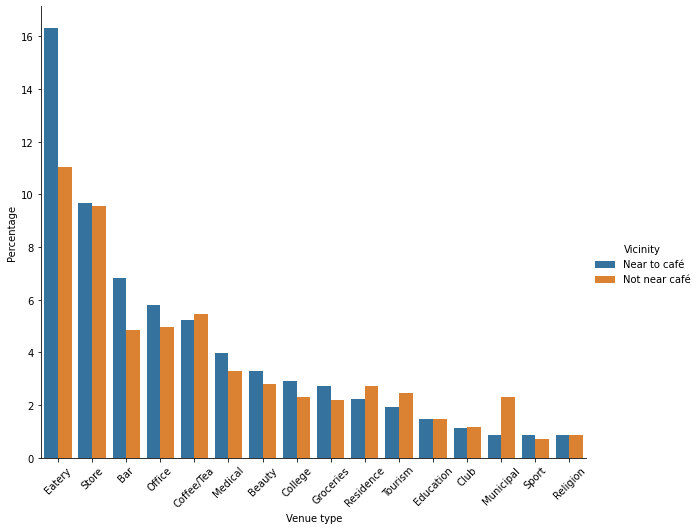

In [64]:
plot = sns.catplot(x='Venue type', 
            y='Percentage', 
            hue='Vicinity',
            aspect=1.2,
            data=grouped_df,
            kind='bar',
            height=7,
            saturation=0.7
           )
plot.set_xticklabels(rotation=45)
plt.show()

While there are some similarities betweens these areas, we can see that there are some noticeable differences between those with a board game cafés and those without: areas containing board game cafés have a greater number of bars and eateries than areas without, as well as a much smaller number of municipal buildings. Since there are these differences there is some justification in using nearby venues as a determining factor for whether or not a district would be suitable for a board game café.

It is also worth asking if performing some clustering analysis is worthwhile on the data to see if patterns can be seen in regions surrounding board game cafés, or within cities without.

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [66]:
X_cafe = venues_with_cafe_merge.copy().drop(columns=['Has_board_game_café']).to_numpy()
X_cwc = venues_without_cafe_merge.copy().drop(columns=['Has_board_game_café']).to_numpy()

We will see if there is a good number of clusters to build upon based on the inertia and silhouette score for each clustering; the inertia will decrease as points get closer to centroids (so it will decrease as we increase our number of clusters), wheras the silhouette score will increase (it is a score between -1 and 1) as points are contained within close clusterings and will decrease after we exceed the optimal number of clusters.

In [67]:
for k_clusters in range(2,21):
    km_cafe = KMeans(n_clusters=k_clusters, random_state=0).fit(X_cafe)
    print(f"{k_clusters}: {silhouette_score(X_cafe, km_cafe.labels_)}, {km_cafe.inertia_}")

2: 0.08557252636936932, 5.43883860532744
3: 0.07200202253256471, 5.204868785827184
4: 0.07180736995284302, 5.020158827047327
5: 0.059728024283653265, 4.81363360249184
6: 0.05384174833751674, 4.698496177771456
7: 0.04517811471625605, 4.61342558428467
8: 0.051281436048316094, 4.538024667846632
9: 0.046139510184305316, 4.460030594392704
10: 0.046289657216673954, 4.410574263436276
11: 0.04362057025712279, 4.349410753743687
12: 0.03839241253748888, 4.319673987128944
13: 0.030122979419171286, 4.306215401409012
14: 0.032323495679472576, 4.227319046908448
15: 0.03839370837187664, 4.2054243259078925
16: 0.04209342717332415, 4.163435169307103
17: 0.04553742795004992, 4.083404868489754
18: 0.031232312413889355, 4.100008393109209
19: 0.029177662444181744, 4.0786477519458275
20: 0.027368456191732945, 4.019694633007575


In [68]:
for k_clusters in range(2,21):
    km_cafe = KMeans(n_clusters=k_clusters, random_state=0).fit(X_cwc)
    print(f"{k_clusters}: {silhouette_score(X_cwc, km_cafe.labels_)}, {km_cafe.inertia_}")

2: 0.046962315310295585, 9.34698965097864
3: 0.048154735146651015, 8.853072366434507
4: 0.048293395509852975, 8.472961264084189
5: 0.04497903796107045, 8.177347267775481
6: 0.04951681550450366, 7.939831640591216
7: 0.04986969750619291, 7.743396004904667
8: 0.0400508946304404, 7.579792389899627
9: 0.034019615591031775, 7.386495937569291
10: 0.027812312384155054, 7.2897995614980085
11: 0.03618693302738169, 7.119023210118348
12: 0.03744984405301122, 7.003917468895459
13: 0.04062816244980011, 6.898308244633611
14: 0.04217030484610573, 6.8030562160131485
15: 0.03202869599338548, 6.74540979329519
16: 0.029001919385062493, 6.681773261814409
17: 0.030344969944980957, 6.616711187349135
18: 0.03749467336906466, 6.466763118766291
19: 0.03715583773313575, 6.4481605851123875
20: 0.040987352323459986, 6.358284418989722


For both the café areas and the cities we see silhouette scores very close to 0, which is indicative of points being on the boundaries of clusters. Furthermore, both silhouette scores are decreasing overall, so points are getting closer to being put into incorrect clusters. All of this suggests that this sort of clustering is not really suitable, and this is perhaps unsurprising given that the data that we are providing is very sparse.

### Training the Model

With our encoded data at hand, we will now train some classifier models with our data. These models will then be able to classify whether or not a region is suitable to house a board game café based on its existing venues, and provide a confidence probability. In particular, we shall consider a logistic regression classifier, a random forest classifier, a support vector classifier and finally a voting classifier, which makes a decision based on the results of the previous three.

We will split the data into a train and test set, with a 80%/20% split, and we will make use of a `MinMaxScaler` to scale the data; this is to avoid dealing with very small values throughout, and this particular scaler was chosen to prevent negative values (as would arise with `StandardScaler`). In addition, we will perform a grid search to determine the optimal choice for the parameters of the logistic regression and the support vector classifiers, namely the normalisation strength parameter $C$ for both and the solver for the logistic regression classifier.

In [69]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, log_loss, f1_score, accuracy_score

In [70]:
# Preparing the data

X = total_venues_merge.copy().drop(columns=['Has_board_game_café']).to_numpy()
y = total_venues_merge['Has_board_game_café'].to_numpy()

# Normalise the data

minmaxscaler = MinMaxScaler().fit(X)
X = minmaxscaler.transform(X)

In [71]:
# Split the data, and include a shuffle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [72]:
# Initiate the models that we perform a grid search over

logreg = LogisticRegression(max_iter=200)
svm = SVC(probability=True)

In [73]:
# Perform a grid searh over C and the solver for logreg and C for SVM

logreg_paramgrid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3], 
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }
svm_paramgrid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3]
            }

logreg_search = GridSearchCV(logreg, param_grid=logreg_paramgrid, refit=True, verbose=1, cv=5) # Refit so we can retrieve best estimator
svm_search = GridSearchCV(svm, param_grid=svm_paramgrid, refit=True, verbose=1, cv=5) # Refit so we can retrieve best estimator

In [74]:
logreg_search.fit(X_train, y_train)
svm_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   26.5s finished


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3]}, verbose=1)

In [75]:
print(f"Best estimators for logistic regression classifier: {logreg_search.best_params_}")
print(f"Best estimators for support vector classifier: {svm_search.best_params_}")

Best estimators for logistic regression classifier: {'C': 0.3, 'solver': 'liblinear'}
Best estimators for support vector classifier: {'C': 1}


In [76]:
print(f"Best score for logistic regression classifier: {logreg_search.best_score_}")
print(f"Best score for support vector classifier: {svm_search.best_score_}")

Best score for logistic regression classifier: 0.8156797331109257
Best score for support vector classifier: 0.8047539616346956


In [77]:
# Implementing the voting classifier using the best logreg and SVM plus a random forest classifier

log_clf = logreg_search.best_estimator_
rnd_clf = RandomForestClassifier()
svm_clf = svm_search.best_estimator_

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.3, max_iter=200,
                                                 solver='liblinear')),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(C=1, probability=True))],
                 voting='soft')

In [78]:
# Evaluating how well each model performed

model_results = dict()

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    model_results[clf.__class__.__name__] = y_pred
    print("Model: {}, Accuracy: {}, LogLoss: {}, F1: {}".format(
        clf.__class__.__name__, 
        accuracy_score(y_test, y_pred), 
        log_loss(y_test, y_pred_prob), 
        f1_score(y_test, y_pred))
         )

Model: LogisticRegression, Accuracy: 0.8540145985401459, LogLoss: 0.388527146776448, F1: 0.8245614035087718
Model: RandomForestClassifier, Accuracy: 0.8321167883211679, LogLoss: 0.43707996095971335, F1: 0.7927927927927928
Model: SVC, Accuracy: 0.8686131386861314, LogLoss: 0.3214295375425205, F1: 0.830188679245283
Model: VotingClassifier, Accuracy: 0.8978102189781022, LogLoss: 0.37034829029972005, F1: 0.8771929824561403


In order to get an idea of how well this model does we will use a confusion matrix for the actual values against the predicted.

In [80]:
def print_confusion_matrix(y_actual, y_predicted, ax):
    data = {'y_actual': y_actual, 
            'y_predicted': y_predicted
           }
    df = pd.DataFrame(data, columns=['y_actual', 'y_predicted'])
    confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual value'], colnames=['Predicted value'])
    
    heatmp = sns.heatmap(ax=ax, 
                         data=confusion_matrix,
                         annot=True, 
                         cbar=False, 
                         cmap='GnBu'
                        )
    return heatmp

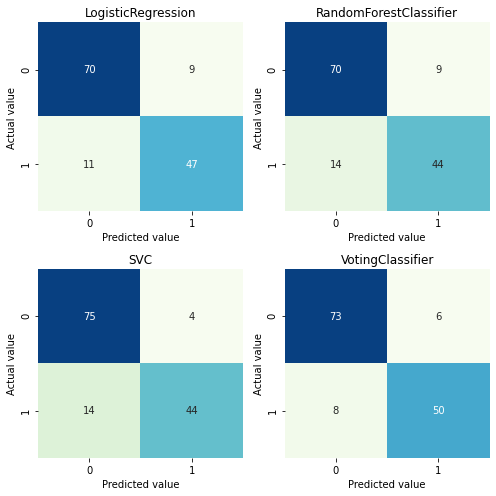

In [81]:
# See the confusion matrix for the four models

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(7, 7))

for ax, model in zip([ax1, ax2, ax3, ax4], list(model_results.keys())):
    yhat = model_results[model]
    ax.set_title(model)
    print_confusion_matrix(y_test, yhat, ax)

fig.tight_layout()
plt.show()

If we compare the values, we can see that the logistic regression model has the highest accuracy and F1 scores, but it has a higher log loss than the voting classifier, thanks to the influence of the support vector classifier. Furthermore, if we compare the confusion matrix for each we see that the support vector and random forest classifiers are most prone to 'pessimistic' labelling, with more true and false negative values, with the random forest classifier being the least accurate overall, with the most false positives as well (tied with the logistic regression classifier).

In comparing the confusion matrices, accuracies and F1 scores, we can see that the voting classifier provides the best choice of model. Whilst it is slower (having to initially calculate the results for three separate models before making a decision) it does provide a noticeable improvement over the other choices, and so we shall use it going forward.

Let's now use this model to determine the feasibility of different districts in Turku.

### Applying the Model to Turku Data

In order to apply our trained model to determine the feasibility of regions in Turku we need to perform a similar process of extracting region data, and from there venue data, for the regions of Turku. We shall make use of the Wikipedia page on the [regions of Turku](https://en.wikipedia.org/wiki/Districts_of_Turku), and from here again make use of the Nominatim query API to obtain latitude and longitude data, as well as the Open Street Map ID for each region; this last piece of information will allow us to retrieve json files containing the polygon describing each region from [this website](http://polygons.openstreetmap.fr/index.py). Finally, we will again utilise the Foursquare API to retrieve the venues within each region.

#### Getting the Turku districts

In [82]:
# Obtain the Turku districts from Wikipedia

turku_url = 'https://en.wikipedia.org/wiki/Districts_of_Turku'
response = requests.get(turku_url)
response

<Response [200]>

The Wikipedia page contains multiple tables corresponding to the different wards within Turku, and so we will collect all of them and then retrieve the name of each district. Each district is hyperlinked and so we will search for the `a` html tag, and remove numerical results that arise from the 6 footnotes on the page. Finally, we shall also remove instances of "District" within the Turku regions given in Roman numerals, as this causes later issues when querying Nominatim.

In [83]:
turku_soup = BeautifulSoup(response.content)

# Obtain all tables

district_tables = turku_soup.find_all('table', attrs={'class':'multicol'})

# Collect hyperlinked text in the tables

turku_districts = [a.text for table in district_tables for a in table.find_all('a')]

# Remove all values arising from footnotes on the page

turku_districts = list(set(turku_districts) - {str(n) for n in range(1, 7)})

# Get rid of instances of 'District' in text

turku_districts = [district.split(' District')[0] for district in turku_districts]

# Store in a dataframe

turku_districts_df = pd.DataFrame(turku_districts, columns=['District'])
turku_districts_df.head()

,District
0,Ruohonpää
1,Pitkämäki
2,VIII
3,II
4,Koroinen


Next, we perform the Nominatim query on each of the districts given in `turku_districts_df`, retrieving its latitude, longitude and OSM ID, which will allow us to obtain a json file detailing the polygons describing each district. We will then combine this with `turku_districts_df`.

In [84]:
district_latlong = [{'Latitude': geolocator.geocode(f"{district}, Turku").latitude, 
                     'Longitude': geolocator.geocode(f"{district}, Turku").longitude, 
                     'OSM_ID': geolocator.geocode(f"{district}, Turku").raw.get('osm_id')
                    }
                    for district in turku_districts_df['District'].to_numpy()
                   ]

In [85]:
# Add the latitudes, longitudes and OSM IDs to the districts

turku_districts_df = turku_districts_df.join(pd.DataFrame(district_latlong), how = 'left')
turku_districts_df.head()

,District,Latitude,Longitude,OSM_ID
0,Ruohonpää,60.466076,22.239700,10764115
1,Pitkämäki,60.460378,22.229007,10764117
2,VIII,60.445306,22.245225,8837208
3,II,60.445324,22.262853,6127718384
4,Koroinen,60.468412,22.292230,10761467


With our dataframe we can now retrieve the polygon json files from the [previously mentioned website](http://polygons.openstreetmap.fr/index.py). Unfortunately, the Nominatim API only returns an individual value for each query, whereas the [Nominatim website](nominatim.openstreetmap.org/) can receive more than one (e.g. if there is a bus stop with the same name as a district), and administrative boundaries will not always appear first in a search. As such, some OSM ID's that we have retrieved will not work, and we need to manually correct them before continuing, as well as their latitude and longitudes. (We will also remove the airport, as it is neither a sensible choice, nor does it provide an administrative boundary result).

In [86]:
turku_districts_df.set_index('District', inplace=True) # To ease searching for incorrect data

# Correct the problematic values

turku_districts_df.loc['Kupittaa', 'OSM_ID'] = 8837204
turku_districts_df.loc['Kupittaa', 'Latitude'] = 60.4470358
turku_districts_df.loc['Kupittaa', 'Longitude'] = 22.29613619745664
turku_districts_df.loc['Kurjenmäki', 'OSM_ID'] = 10762760
turku_districts_df.loc['Kurjenmäki', 'Latitude'] = 60.4398819 
turku_districts_df.loc['Kurjenmäki', 'Longitude'] = 22.281293808478488
turku_districts_df.drop('Turku Airport', axis=0, inplace=True) # Nominatim does not have a region for the airport, and I don't think it is the best region anyway
turku_districts_df.loc['Iso-Heikkilä', 'OSM_ID'] = 10762963
turku_districts_df.loc['Iso-Heikkilä', 'Latitude'] = 60.448452599999996 
turku_districts_df.loc['Iso-Heikkilä', 'Longitude'] = 22.22933169274955
turku_districts_df.loc['VII', 'OSM_ID'] = 8837207
turku_districts_df.loc['VII', 'Latitude'] = 60.450297250000006 
turku_districts_df.loc['VII', 'Longitude'] = 22.257027756348627
turku_districts_df.loc['Jänessaari', 'OSM_ID'] = 10761568
turku_districts_df.loc['Jänessaari', 'Latitude'] = 60.4212874 
turku_districts_df.loc['Jänessaari', 'Longitude'] = 22.185200616184922
turku_districts_df.loc['Korppolaismäki', 'OSM_ID'] = 10761470
turku_districts_df.loc['Korppolaismäki', 'Latitude'] = 60.4306364 
turku_districts_df.loc['Korppolaismäki', 'Longitude'] = 22.2395476128064
turku_districts_df.loc['Oriniemi', 'OSM_ID'] = 10762411
turku_districts_df.loc['Oriniemi', 'Latitude'] = 60.3923785 
turku_districts_df.loc['Oriniemi', 'Longitude'] = 22.17387715358517
turku_districts_df.loc['Särkilahti', 'OSM_ID'] = 10762414
turku_districts_df.loc['Särkilahti', 'Latitude'] = 60.4163181 
turku_districts_df.loc['Särkilahti', 'Longitude'] = 22.19779843118863
turku_districts_df.loc['Paattinen', 'OSM_ID'] = 10764096
turku_districts_df.loc['Paattinen', 'Latitude'] = 60.644726 
turku_districts_df.loc['Paattinen', 'Longitude'] = 22.421241777144488
turku_districts_df.loc['Katariina', 'OSM_ID'] = 10762764
turku_districts_df.loc['Katariina', 'Latitude'] = 60.4092325 
turku_districts_df.loc['Katariina', 'Longitude'] = 22.27899545560333
turku_districts_df.loc['Nummi', 'OSM_ID'] = 10761468
turku_districts_df.loc['Nummi', 'Latitude'] = 60.45780355
turku_districts_df.loc['Nummi', 'Longitude'] = 22.30523268665229
turku_districts_df.loc['Mäntymäki', 'OSM_ID'] = 10762761
turku_districts_df.loc['Mäntymäki', 'Latitude'] = 60.4371589 
turku_districts_df.loc['Mäntymäki', 'Longitude'] = 22.267707856610002
turku_districts_df.loc['II', 'OSM_ID'] = 8837202
turku_districts_df.loc['II', 'Latitude'] = 60.446920950000006 
turku_districts_df.loc['II', 'Longitude'] = 22.27735229048366

In [87]:
# Reset the index

turku_districts_df.reset_index(drop=False, inplace=True)

We will now define a function for retrieving the json files using the OSM IDs in our dataframe

In [88]:
import urllib

# Cache for storing retrieved data and speed up repeated calls

polygon_cache = dict()

def get_polygon(id):
    
    # Function for obtaining the region polygon for a district with OSM ID 'id'.
    
    if (id in polygon_cache):
        pass
        
    json_url = f"http://polygons.openstreetmap.fr/get_geojson.py?id={id}&params=0"
    response = urllib.request.urlopen(json_url)
    try:
        gj = json.loads(response.read())
        polygon_cache[id] = gj
        
    except:
        print(f"Id {id} didn't produce a geojson file")

In [89]:
# Retrieve the json file and save it as a value in the dictionary polygon_cache for each district

for id in turku_districts_df['OSM_ID'].to_numpy():
    get_polygon(str(id))

In [90]:
# Sanity check that all districts have been included in polygon_cache; should equal 0

polygon_keys = [int(key) for key in list(polygon_cache.keys())]
missing_keys = list(set(turku_districts_df['OSM_ID'].values) - set(polygon_keys))
len(missing_keys)

0

In [91]:
# Collect all polygon features within one dictionary for later

feature_list = [{'type': 'Feature', 'id': int(id), 'geometry': polygon} for id, polygon in polygon_cache.items()]
polygons = {'type': 'FeatureCollection', 'features': feature_list}

In [92]:
# Visualise the regions of Turku

latitude, longitude = 60.458038443754916, 22.267463230122978

map_tku = folium.Map(location=[latitude, longitude], zoom_start=11)

for gj in polygon_cache.values():
    folium.GeoJson(gj).add_to(map_tku)

for lat, lng, dist in zip(turku_districts_df['Latitude'], turku_districts_df['Longitude'], turku_districts_df['District']):
    label = dist
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5,
        popup=label,
        color='#f96706',
        weight=2,
        fill=True,
        fill_color='#F9E106',
        fill_opacity=0.8,
        parse_html=False).add_to(map_tku)

map_tku

Note that the gap in regions near to the port is due to a large housing project that is currently not ascribed a district.

#### Getting the venues in each district


In [93]:
columns = {'District': 'District'}
turku_district_venues = get_local_venues(turku_districts_df, col_dict=columns)

print(turku_district_venues.shape)
turku_district_venues.head()

(5916, 3)


,District,Venue_name,Venue_cat
0,Ruohonpää,Muovitukku,Miscellaneous Shop
1,Ruohonpää,Gullichsen's,Caribbean Restaurant
2,Ruohonpää,ford fiesta,Cable Car
3,Ruohonpää,tildu's,Residential Building (Apartment / Condo)
4,Ruohonpää,Koskikaukonen Oy,Construction & Landscaping


Now that we have venue data it is time to encode them using the same one-hot encoder we used in the training stage.

In [94]:
turku_onehot = turku_district_venues[['District', 'Venue_cat']]
turku_ohe = ohe.transform(turku_onehot[['Venue_cat']])
turku_onehot = turku_onehot.join(pd.DataFrame(turku_ohe.toarray(), columns=ohe.categories_[0]), how='left')
turku_onehot.head()

,District,Venue_cat,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airfield,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Architecture Firm,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Blood Donation Center,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Borek Place,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Chaat Place,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Cricket Pitch,College Engineering Building,College Football Field,College Gym,College History Building,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Tennis Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Conference Room,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dam,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Emilia Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food

In [95]:
# Merge the venues by district

turku_merge = turku_onehot.groupby('District').mean()
print(turku_merge.shape)
turku_merge.reset_index(inplace=True)
turku_merge.head()

(78, 724)


,District,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Agriturismo,Airfield,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Architecture Firm,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Blood Donation Center,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Borek Place,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Chaat Place,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Cricket Pitch,College Engineering Building,College Football Field,College Gym,College History Building,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Tennis Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference,Conference Room,Construction & Landscaping,Convenience Store,Convention,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dairy Store,Dam,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drive-in Theater,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Emilia Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink S

In [96]:
# Use the same scaler as we did on the training data

X_turku = minmaxscaler.transform(turku_merge.drop(columns=['District']).to_numpy())

In [97]:
# Obtain values from the logistic regression model

y_turku = voting_clf.predict(X_turku)
y_turku_prob = voting_clf.predict_proba(X_turku)

In [98]:
# Add the probabilities to the districts, and add a column expressing the yes probability as a value between 0 and 100

turku_probs = turku_merge[['District']].join(pd.DataFrame(y_turku_prob, columns=['No', 'Yes']), how='left')
turku_probs['Yes%'] = 100 * turku_probs['Yes']
turku_probs.head()

,District,No,Yes,Yes%
0,Artukainen,0.712362,0.287638,28.763832
1,Friskala,0.650661,0.349339,34.933889
2,Haarla,0.728224,0.271776,27.177591
3,Halinen,0.834463,0.165537,16.553733
4,Harittu,0.705645,0.294355,29.435524


In [99]:
# Combine turku_districts_df and turku_probs along the District column (we set it as index for both and the reset the index after)

turku_districts_df = turku_districts_df.set_index('District').join(turku_probs.set_index('District'), how='left')
turku_districts_df = turku_districts_df.reset_index(drop=False)
turku_districts_df.head()

,District,Latitude,Longitude,OSM_ID,No,Yes,Yes%
0,Ruohonpää,60.466076,22.239700,10764115,0.525789,0.474211,47.421149
1,Pitkämäki,60.460378,22.229007,10764117,0.655149,0.344851,34.485091
2,VIII,60.445306,22.245225,8837208,0.782530,0.217470,21.747019
3,II,60.446921,22.277352,8837202,0.672343,0.327657,32.765690
4,Koroinen,60.468412,22.292230,10761467,0.692905,0.307095,30.709491


In [100]:
turku_districts_df.sort_values(by='Yes%', ascending=False)

,District,Latitude,Longitude,OSM_ID,No,Yes,Yes%
60,VI,60.454760,22.269700,8837206,0.380652,0.619348,61.934778
73,Kupittaa,60.447036,22.296136,8837204,0.411339,0.588661,58.866135
40,VII,60.450297,22.257028,8837207,0.457185,0.542815,54.281543
0,Ruohonpää,60.466076,22.239700,10764115,0.525789,0.474211,47.421149
15,I,60.453045,22.285115,8837203,0.532320,0.467680,46.768009
11,Itäharju,60.449068,22.308755,10762972,0.545381,0.454619,45.461942
61,Peltola,60.426665,22.299502,10762771,0.572678,0.427322,42.732160
16,Pohjola,60.456833,22.255450,10761464,0.579818,0.420182,42.018189
25,Jäkärlä,60.539223,22.354991,10764099,0.581731,0.418269,41.826887
74,Koivula,60.421046,22.303189,10762974,0.599873,0.400127,40.012667


### Visualising the Results

Now we have the probabilities for each region, as well as their corresponding polygons, we can build a choropleth map for our results.

In [101]:
latitude, longitude = 60.475, 22.267463230122978

map_tku = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.Choropleth(
    geo_data=polygons,
    name="choropleth",
    data=turku_districts_df,
    columns=["OSM_ID", "Yes%"],
    key_on="feature.id",
    fill_color="RdYlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Suitability for a board game café (%)",
).add_to(map_tku)

folium.LayerControl().add_to(map_tku)

map_tku